## Neural Network

This jupyter notebook implements the neural network model using convolutional layers

In [362]:
#Import libraries
from torchvision.io import read_image
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torch 
import torch.nn as nn # basic building block for neural neteorks
import torch.nn.functional as F # import convolution functions like Relu
import torch.optim as optim # optimzer
from torch.utils.data import WeightedRandomSampler
import os
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from sklearn.metrics import recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from XRayDataset import XRayDataset
from dataloader import train_path, test_path, val_path
import matplotlib.pylab as plt
import copy
import random
%matplotlib inline

In [363]:
random.seed = 123

In [364]:
# create CNN class 
class CustomNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        # model hyperparameters 
        self.epochs = 30
        self.batch_size = 16 
        self.learning = 0.005
        self.momentum = 0.9
        self.weighted_sample = False
        self.lr_decay = True
        # define network layers 
        self.LeNet = nn.Sequential(
            nn.Sequential(
                nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
                nn.BatchNorm2d(6),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ),
            nn.Sequential(
                nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
                nn.BatchNorm2d(16),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2)
            ),
            nn.Flatten(),
            nn.Linear(16 * 61 * 61, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 2),
            nn.ReLU()
        )

    def forward(self, x):
        out = self.LeNet(x)
        return out


In [365]:
# Create model using class 
model = CustomNeuralNetwork()

In [366]:
# Load data 
resize = T.Compose([
            T.ToPILImage(), 
            T.Grayscale(num_output_channels=1),
            T.Resize((int(256), int(256))), # Resize the image to match median ratio using median length, we can try later with smaller length 
            T.ToTensor()
        ])
        
transforms = T.Compose([
    T.ToPILImage(),
    T.Grayscale(num_output_channels=1),
    T.Resize((256, 256)),
    T.RandomSolarize(2, p=0.5),
    T.RandomHorizontalFlip(p=0.5),
    # # T.RandomRotation(15),
    # T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor()
])

# create Xray dataset class for train, val, test 
training_data = XRayDataset(train_path, resize)
val_data = XRayDataset(val_path, resize)
test_data = XRayDataset(test_path, resize)

if model.weighted_sample is False: 
    train_dataloader = DataLoader(training_data, batch_size=model.batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=model.batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=model.batch_size, shuffle=True)
else: 
    # Create weighted sampler
    counts = {'test': {'PNEUMONIA': 390, 'NORMAL': 234},
    'train': {'PNEUMONIA': 3875, 'NORMAL': 1341},
    'val': {'PNEUMONIA': 8, 'NORMAL': 8}}
    # calculate weights and create samplers 
    train_weights = [1/v for v in counts['train'].values()]
    train_sampler = WeightedRandomSampler(weights=train_weights,num_samples=2)
    val_weights = [1/v for v in counts['val'].values()]
    val_sampler = WeightedRandomSampler(weights=val_weights,num_samples=2)
    test_weights = [1/v for v in counts['test'].values()]
    test_sampler = WeightedRandomSampler(weights=test_weights,num_samples=2)

    train_dataloader = DataLoader(training_data, batch_size=model.batch_size, sampler=train_sampler)
    val_dataloader = DataLoader(val_data, batch_size=model.batch_size, sampler=val_sampler)
    test_dataloader = DataLoader(test_data, batch_size=model.batch_size, sampler=test_sampler)

In [367]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.SGD(model.parameters(), lr=model.learning, momentum=model.momentum)
scheduler_lr = StepLR(optimizer, 
                   step_size = 4, # Period of learning rate decay
                   gamma = 0.5)

scheduler_eilr = ExponentialLR(optimizer, 
                          gamma = 0.5) # Multiplicative factor of learning rate decay.

In [368]:
# Train and validate the network
train_losses = []
train_accuracies = []
train_recalls = []
val_accuracies = []
val_recalls = []
val_losses = []
test_losses = []
test_accuracies = []
test_recalls = []

steps_check_val = 1
steps_check_test = 5

for epoch in range(model.epochs):
    # TRAIN
    model.train()  # Make sure gradient tracking is on, and do a pass over the data
    running_loss = 0.0
    y_true = np.array([])
    y_predict = np.array([])
    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        optimizer.zero_grad()  # zero the parameter gradients
        outputs = model(inputs)  # forward pass
        label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
        labels_tensor = torch.tensor([label_dict[label] for label in labels])
        loss = criterion(outputs, labels_tensor)  # calculate loss
        loss.backward()  # backward pass
        optimizer.step()  # update weights
        running_loss += loss.item()
        y_true = np.concatenate((y_true, labels_tensor.numpy()))
        y_pred_batch = np.argmax(outputs.detach().numpy(), axis=1)
        y_predict = np.concatenate((y_predict, y_pred_batch))
    
    epoch_accuracy = accuracy_score(y_true, y_predict)
    epoch_recall = recall_score(y_true, y_predict, average='binary')
    train_losses.append(running_loss)
    train_accuracies.append(epoch_accuracy)
    train_recalls.append(epoch_recall)

    if model.lr_decay:
        scheduler_lr.step()
        

    #VALIDATION
    if (epoch+1) % steps_check_val == 0: 
        val_running_loss = 0.0
        with torch.no_grad(): # don't keep track of the gradients in the validation part
            model.eval() 
            y_true_val = np.array([])
            y_predict_val = np.array([])
            for i, data in enumerate(val_dataloader):
            # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                outputs = model(inputs)  # forward pass
                label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
                labels_tensor = torch.tensor([label_dict[label] for label in labels])
                y_true_val = np.concatenate((y_true_val, labels_tensor.numpy()))
                y_predict_val = np.concatenate((y_predict_val, outputs.argmax(dim=1).numpy()))
                val_loss = criterion(outputs, labels_tensor)  # calculate loss
                val_running_loss += val_loss.item()

            val_epoch_accuracy = accuracy_score(y_predict_val, y_true_val)
            val_epoch_recall = recall_score(y_true_val, y_predict_val, average='binary')
            val_losses.append(val_running_loss)
            val_accuracies.append(val_epoch_accuracy)
            val_recalls.append(val_epoch_recall)

    if (epoch+1) % steps_check_test == 0:
        test_running_loss = 0.0
         with torch.no_grad():
            model.eval()
            y_true_test = np.array([])
            y_predict_test = np.array([])
            for i, data in enumerate(test_dataloader):
        # get the inputs; data is a list of [inputs, labels]
                inputs, labels = data
                outputs = model(inputs)  # forward pass
                label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
                labels_tensor = torch.tensor([label_dict[label] for label in labels])
                y_true_test = np.concatenate((y_true_test, labels_tensor.numpy()))
                y_predict_test = np.concatenate((y_predict_test, outputs.argmax(dim=1).numpy()))
                test_loss = criterion(outputs, labels_tensor)  # calculate loss
                test_running_loss += val_loss.item()

            test_epoch_accuracy = accuracy_score(y_true_test, y_predict_test)
            test_epoch_recall = recall_score(y_true_test, y_predict_test, average='binary')
            test_losses.append(test_running_loss)
            test_accuracies.append(test_epoch_accuracy)
            test_recalls.append(test_epoch_recall)

In [369]:
# y_predict, y_true, train_losses, train_accuracies, train_recalls = train(model)
print("y_predict", y_predict)
print("y_true", y_true)
print(train_losses)
print("Training accuracies",train_accuracies)
print("Training recalls", train_recalls)
print("Training losses", train_losses)

print("Validation accuracies",val_accuracies)
print("Validation recalls", val_recalls)
print("Validation loss", val_losses)

y_predict [0. 0. 0. ... 0. 1. 0.]
y_true [0. 0. 0. ... 0. 1. 0.]
[173.17942634224892, 64.23008490120992, 43.32047666888684, 37.92399867810309, 29.023491913918406, 25.010217483737506, 22.930964813102037, 19.485165710677393, 15.842066971294116, 12.714494304731488, 10.79464921520048, 8.14823976840853, 5.686092905467376, 4.766225503219175, 4.293512669057236, 3.568273561284059, 2.8923948011106404, 2.6996519378153607, 2.197881980644638, 1.9220524790289346, 1.943419261224335, 1.5773004944203421, 1.4188977404439242, 1.3635924131081083, 1.282061684238215, 1.2622582591109222, 1.0463887565447294, 1.0866758584725176, 1.0065733248928836, 0.9067120528902706]
Training accuracies [0.734325445230544, 0.9077823859477921, 0.9370578189802391, 0.9470602585996585, 0.9609660892900708, 0.9646255184191266, 0.9673090997804342, 0.970724566967553, 0.9763356916321054, 0.9826787021224689, 0.9843864357160284, 0.9895096364967065, 0.9931690656257623, 0.9948767992193218, 0.9946328372773847, 0.9970724566967553, 0.997072

In [370]:
# #5. Test model
# test_losses = []
# test_running_loss = 0.0
# test_accuracies = []
# test_recalls = []

# with torch.no_grad():
#     model.eval()
#     y_true_test = np.array([])
#     y_predict_test = np.array([])
#     for i, data in enumerate(test_dataloader):
#         # get the inputs; data is a list of [inputs, labels]
#         inputs, labels = data
#         outputs = model(inputs)  # forward pass
#         label_dict = {"PNEUMONIA": 0, "NORMAL": 1}
#         labels_tensor = torch.tensor([label_dict[label] for label in labels])
#         y_true_test = np.concatenate((y_true_test, labels_tensor.numpy()))
#         y_predict_test = np.concatenate((y_predict_test, outputs.argmax(dim=1).numpy()))
#         test_loss = criterion(outputs, labels_tensor)  # calculate loss
#         test_running_loss += val_loss.item()

#     test_epoch_accuracy = accuracy_score(y_true_test, y_predict_test)
#     test_epoch_recall = recall_score(y_true_test, y_predict_test, average='binary')
#     test_losses.append(test_running_loss)
#     test_accuracies.append(test_epoch_accuracy)
#     test_recalls.append(test_epoch_recall)

In [371]:
print("test accuracy", test_accuracies)
print("test recall", test_recalls)

unique, counts = np.unique(y_predict_test, return_counts=True)

# print the unique values and their counts
for value, count in zip(unique, counts):
    print(f"{value}: {count}")


test accuracy [0.9617672047578589]
test recall [0.9127725856697819]
0.0: 867
1.0: 310


ValueError: x and y must have same first dimension, but have shapes (30,) and (6,)

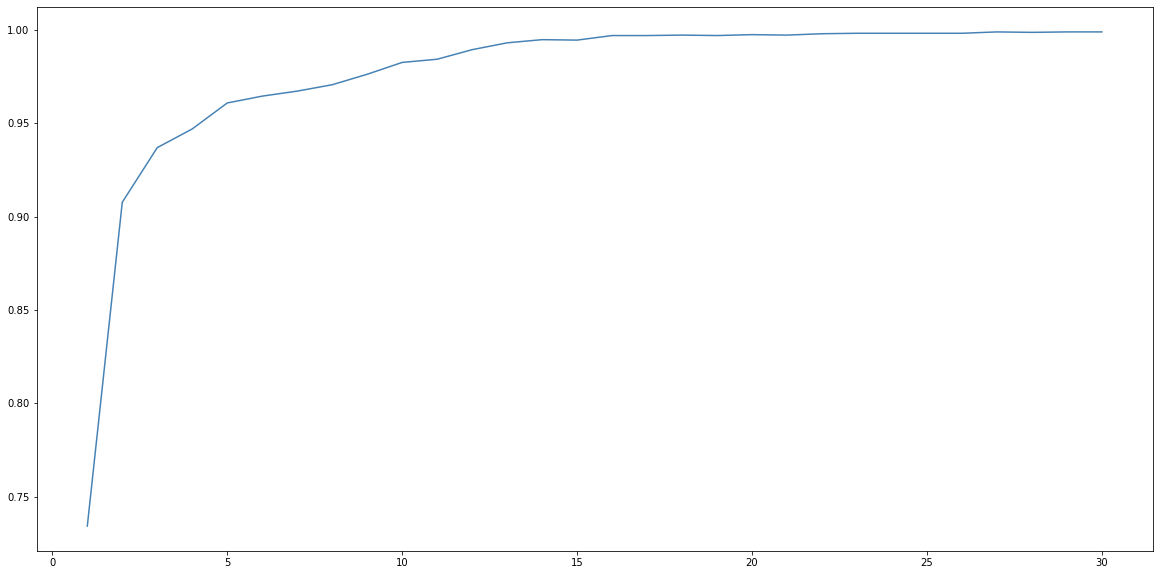

In [372]:
test_accuracy =  test_accuracies * model.epochs
epochs = [i for i in range(1,model.epochs+1)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(epochs, train_accuracies, color="steelblue", label= 'Train')
ax.plot(epochs, val_accuracies, color="lightblue", ls='dashed', label='Validation')
ax.plot(epochs, test_accuracy, color= "coral", ls='dashed', label='Test Mean')
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
plt.show()

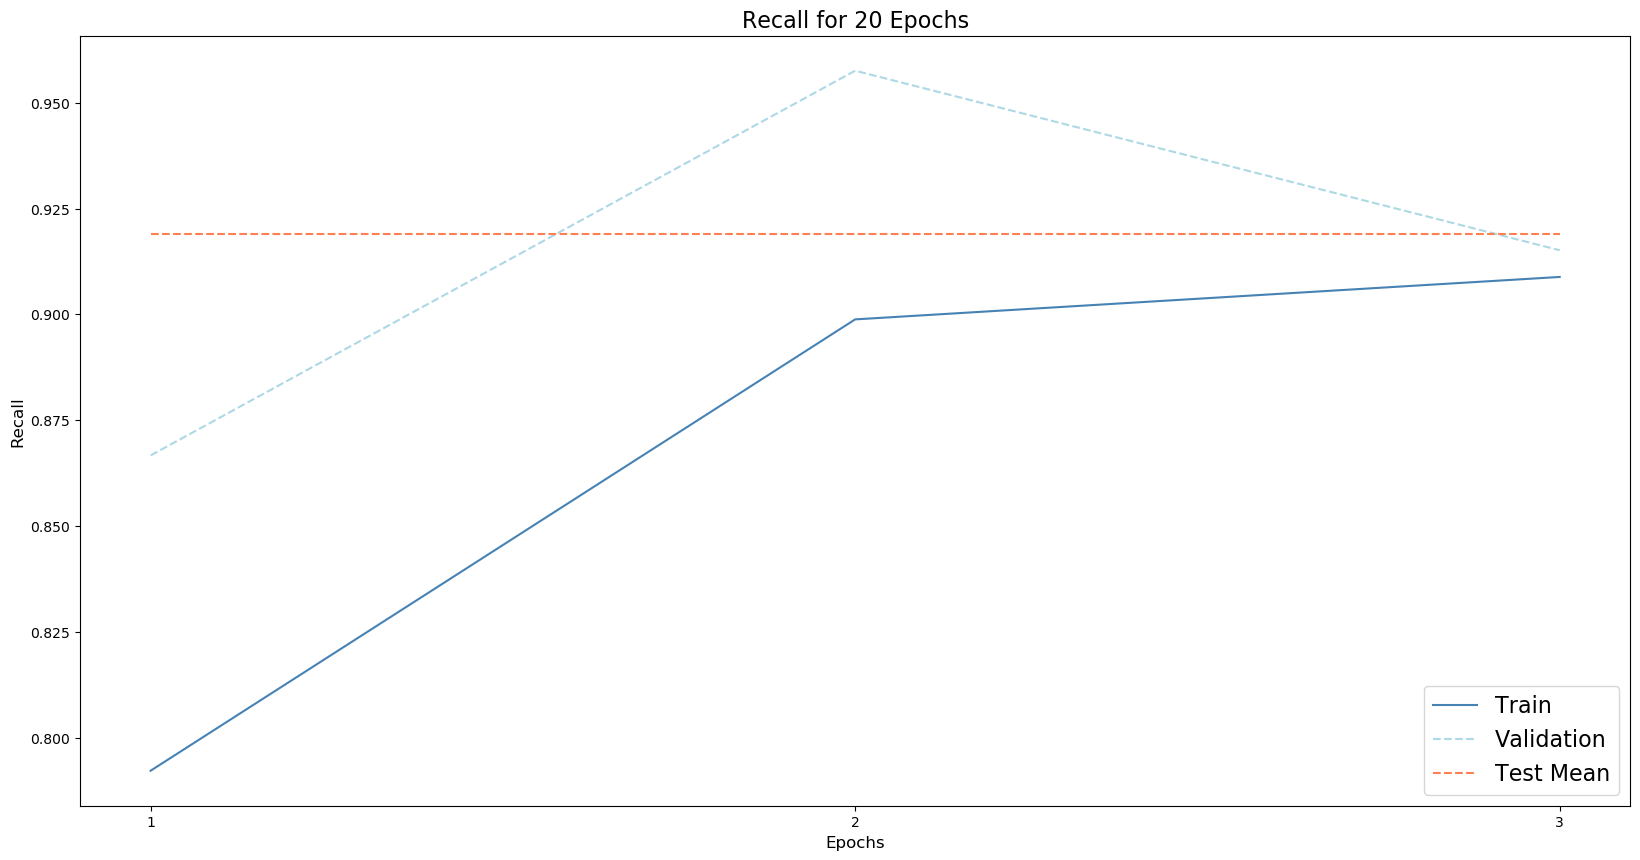

In [ ]:
test_recalls_list = test_recalls * model.epochs
epochs = [i for i in range(1,model.epochs+1)]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
ax.plot(epochs, train_recalls, color="steelblue", label= 'Train')
ax.plot(epochs, val_recalls, color="lightblue", ls='dashed', label='Validation')
ax.plot(epochs, test_recalls_list, color= "coral", ls='dashed', label='Test Mean')
ax.set_xticks(epochs)
ax.legend(loc="lower right", fontsize=16)
ax.set_xlabel("Epochs", fontsize=12)
ax.set_ylabel("Recall", fontsize=12)
ax.set_title("Recall for 20 Epochs", fontsize=16)
plt.show()

In [ ]:
print(val_accuracies)
print(val_recalls)

unique, counts = np.unique(y_predict_val, return_counts=True)

# print the unique values and their counts
for value, count in zip(unique, counts):
    print(f"{value}: {count}")

[0.9448275862068966, 0.9155172413793103, 0.9431034482758621]
[0.8666666666666667, 0.9575757575757575, 0.9151515151515152]
0.0: 410
1.0: 170


In [ ]:
#Confusion matrix
# Calculate the confusion matrix using the accumulated true labels and predictions
cm = confusion_matrix(true_labels, predicted_labels)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Pneumonia", "Normal"])
disp.plot()